# ENERGY BASE MODELS (EBM)

Energy-based models attempt to model the true datagenerating distribution using a Boltzmann distribution where $E(x)$ is know as the energy function (or score) of an observation x
<div style="font-size: 20px;">
$
    p(x) = \frac{e^{-E(x)}}{\int_{\hat{x} \in X} e^{-E(\hat{x})}}
$
</div>

The energy function 
<div style="font-size:20px;">
$E_\theta(x)$ 
</div> 
is a neural network with parameters $\theta$ that can transform an input image $x$ into a scalar value.

For generate new samples that have a lower energy score we will use a technique called Langevin dynamics, which makes use of the fact that we can compute the gradient of the energy function with respect to its input. We will start from a random point in the sample space and take small steps in the opposite direction of the calculated gradient, we will gradually reduce the energy function thus the random noise should transform into an image that resembles an observation from the training set.
In orgder to lower a risk of falling into local minima we will add a small amount of random noise to the input as we travel across the sample space.
Langevin dynamic formula is:
$
      \tilde{x}^k \leftarrow \tilde{x}^{k-1} - \eta \nabla_x E_\theta(\tilde{x}^{k-1}) + \omega, 
   $

Visualization of Langevin gradient descent in 3-D space:

<img src="./images/ebm-gradint_descent.png" width="450" />

Important to note that in compare with back propogation techniques with Langevin dynamics we keep the neural network weights fixed and calculate the gradient of the output(i.e. fake generated image) with respect to input(i.e. real image)

## Imports

In [1]:
from tensorflow.keras import (
    datasets,
    layers,
    activations,
    models,
    metrics,
    optimizers,
    callbacks
)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
from pathlib import Path
import math

2024-11-17 08:29:53.360448: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 08:29:53.429679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 08:29:53.429752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 08:29:53.440679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 08:29:53.457854: I tensorflow/core/platform/cpu_feature_gua

## Global Settings

In [2]:
# Afjust output thus image matrix's row can fit on a screen
np.set_printoptions(linewidth=200)
np.set_printoptions(threshold=np.inf)

## Functions

In [3]:
def preprocess_img(imgs):
    
    imgs= (imgs.astype('float32') - 127.5) / 127.5

    # (0,0) - means do not change number of images in the batch
    # (2,2),(2,2) - means create a frame thick=2
    # constant_values - means fill fram with -1.0
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values = -1.0 )
    imgs = np.expand_dims(imgs, -1)

    return imgs

def sample_batch(dataset):
    batch= dataset.take(1).get_single_element()

    if isinstance(batch, tuple):
        batch= batch[0]

    return batch.numpy()


def display_mnist_img_tf(img_tf):

    if img_tf.max() > 1.0:
        img_tf= img_tf / 255.0
    elif img_tf.min() < 0.0:
        img_tf= (img_tf + 1.0) / 2.0
        
    plt.figure(figsize=(3,3))
    plt.imshow(img_tf[0].astype('float32'),cmap='gray')
    plt.axis('off')
    plt.show()

def display_img(images, n=1, fig_size=(20,3), c_map='gray', as_type='float32', save_to=None):
    if save_to is not None:
        oFull_path=Path(save_to)
        oPath=Path(oFull_path.parent)

        if not oPath.exists():
            oPath.mkdir(parents=True, exist_ok=True)

    if images.max() > 1.0:
        images=images/255.0
    elif images.min() < 0.0:
        images=(images+1.0)/2.0

    plt.figure(figsize=fig_size)
    for i in range(n):
        _=plt.subplot(1,n,i+1)
        plt.imshow(images[i].astype(as_type), cmap=c_map)
        plt.axis('off')
        
        
    if save_to:
        plt.savefig(save_to)

    plt.show()

## LOAD AND PRE-PROCESS DATA

In [4]:
%%time
batch_size= 128
(x_train, _), (x_test, _) = datasets.mnist.load_data()
print(f'x_train.type: {type(x_train)}')

x_train.type: <class 'numpy.ndarray'>
CPU times: user 122 ms, sys: 40.9 ms, total: 163 ms
Wall time: 174 ms


In [5]:

print(f'x_train.shape: {x_train.shape}',end='\n')
print(f'x_test.shape: {x_test.shape}',end='\n')
print(f'Number of batches per 1 epoch: {int(math.modf(math.ceil(x_train.shape[0] / batch_size))[1])}')

print(f'Image: {x_train[0]}')

x_train.shape: (60000, 28, 28)
x_test.shape: (10000, 28, 28)
Number of batches per 1 epoch: 469
Image: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  3

In [6]:
%%time
# Normalize image data from the discretre range of [0,255] to continous range [-1,1]
x_train= preprocess_img(x_train)
x_test= preprocess_img(x_test)


CPU times: user 106 ms, sys: 183 ms, total: 289 ms
Wall time: 288 ms


In [7]:

print(f'aa {x_train[0, :, :, 0]}')

aa [[-1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        

2024-11-17 08:29:57.813074: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 08:29:57.974888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 08:29:57.974943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 08:29:57.980649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 08:29:57.980704: I external/local_xla/xla/stream_executor

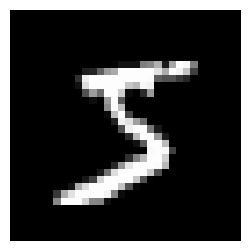

CPU times: user 517 ms, sys: 304 ms, total: 821 ms
Wall time: 969 ms


In [8]:
%%time
# Split dataset by sliics each 128 images
x_train= tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
x_test= tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)

display_mnist_img_tf(sample_batch(x_train))

## EBM

### NN Architecture

Let's consider our model step by step

```python
ebm_input= layers.Input(
    shape=(img_size, img_size, ch_n)
)
```
Here we define our input layer shape on 32x32x1, i.e. b&w image with the size 32x32

```python
x= layers.Conv2D(
    16,
    kernel_size=5,
    strides=2,
    padding='same',
    activation= activations.swish
)(ebm_input)
```

Here we pass in tensor shape 32x32x1 and transform it to to the shape of 16x16x16, and here is why
1. Input size 32x32 we devide by stride size and thus we have an image size 16x16.
2. The last 16 is our channels, so instead of 1 as of input, by the output we will have a 16 each channel will be devoted to separate feature
3. Our weights calculates as follow kernel size 5x5 x input channels size whih is giving us in total 5x5x1 = 25
4. Then we multupy num of params per feature x number of features and add bias equals to 16 - 1 bias per channel
5. 25X16+16=416
6. (3×3×16×32)+32=144×32+32=4608+32=4640 (3x3x16 - is the kernel size)
7. (3x3x32x64)+64=18496

In [9]:
img_size= 32
ch_n= 1

ebm_input= layers.Input(
    shape=(img_size, img_size, ch_n)
)

x= layers.Conv2D(
    16,
    kernel_size=5,
    strides=2,
    padding='same',
    activation= activations.swish
)(ebm_input)

x= layers.Conv2D(
    32,
    kernel_size=3,
    strides=2,
    padding='same',
    activation=activations.swish
)(x)
x= layers.Conv2D(
    64,
    kernel_size=3,
    strides=2,
    padding='same',
    activation=activations.swish
)(x)
x= layers.Conv2D(
    64,
    kernel_size=3,
    strides=2,
    padding='same',
    activation=activations.swish
)(x)

x= layers.Flatten()(x)
x= layers.Dense(
    64,
    activation= activations.swish
)(x)

# The output is the single number known as E-energy
# The energy represents likelihood. The lower the energy - the higher is likelihood
ebm_output= layers.Dense(1)(x)

model= models.Model(ebm_input, ebm_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,993 (300.75 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 0 (0.00 B)

### Sampling

We are going to sampling based on Markov's Chain Momte Carlo using a Langevin Dynamics
$
      \tilde{x}^k \leftarrow \tilde{x}^{k-1} - \eta \nabla_x E_\theta(\tilde{x}^{k-1}) + \omega, 
$


#### Algorithm Structure

1. **Initialization:**  
Sample an initial value $\tilde{x}^k, k=1$ from a Gaussian or uniform distribution. This is a random starting point for our Markov chain.

2. **Main Loop  
Steps (k = 1) to (K):**
```python
for _ in range(steps):
```
- Each step moves us closer to more probable samples using two operations:

   - **Gradient Step:**  
   $
      \tilde{x}^k \leftarrow \tilde{x}^{k-1} - \eta \nabla_x E_\theta(\tilde{x}^{k-1}) + \omega, 
   $
  where $\eta$ is the step size, controlling how far we move in the opposite direction of the gradient to increase probability and $\omega \sim \mathcal{N}(0, \sigma)$ is random noise.

$E_\theta(\tilde{x}^{k-1})$ i.e. 
```python 
out_score= model(in_imgs)  
```

$\nabla_x$ i.e.
```python
grads= tape.gradient(out_score, in_imgs)  
```

$\omega \sim \mathcal{N}(0, \sigma)$ i.e.
```python
in_imgs += tf.random.normal(in_imgs.shape, mean=0, stddev=noise)
```

  - **Noise Addition:**  
  $
  \tilde{x}^k + \omega
  $
  where $\omega \sim \mathcal{N}(0, \sigma)$ is random noise sampled from a normal distribution with mean zero and standard deviation $\sigma$.
  
  This noise helps to prevent getting stuck in local minima, making the process more robust by introducing randomness.

**Result:**

After completing $\(K\)$ steps (where $\(K\)$ is a hyperparameter that determines the number of iterations), we obtain the sample 
$
x_{\text{sample}} = \tilde{x}^K
$
which reflects the probability distribution described by the energy-based model.

In [10]:
def generate_samples(model, in_imgs, steps, step_size, noise, return_img_per_step=False):
    '''
    Generates samples from an ebm based on Markov Chain Monte Carlo using Langevin Dynamics.

    This functions performs sampling by applying a MCMC method based on Langevin Dynamics. The algorythm, once starting from
    a compleetly random image, them updates it iteratively by adding noise and using the gradienf of the energy model to change the image so that the likelihood
    is increasing as well energy is decreasing on each iteration. 

    Parameters:
    -----------
    model: tf.keras.Model
        The EBM model used to compute the energy scores
    in_imgs: tf.Tensor
        Initialy input images
    steps: int
        The number of steps to perform in the Langevin Dynamics chain
    step_size: float
        Learning rate nu in the MCMC algorythm
    noise: float
        Standard deviation of the Gaussian noise added to the input images at each step
    return_img_per_step: bool, optional (default=False)
        If True, returns all intermediate images for each step of the MCMC chain. Otherwise only returns the final set of images.

    Returns:
    --------
    tf.Tensor
        If 'return_img_per_step' is False, returns the final step of generated samples.
        Else, returns a tensor containing intermediate images for each step of the MCMC chain with shape (steps, ...)

    Notes:
    ------
    - The input images are iteratively updated using the gradient of the energy function and additive Gaussian noise to explore
      the modeled distribution.
    - Pixel values are clipped within the range [-1,1] to ensure they remain within a valid range.
    - Gradients are clipped to a small range [-.03,.03] to avoid large gradients that could destabilize the sampling process
    
    '''
    
    # If return_img_per_each_step=True, store images in the list
    imgs_per_step= []

    for _ in range(steps):
        # Add random noise from normal distribution. For every pixel in image we generate a ranodom noise 
        # from normal distribution with 0 mean and standard deviation
        in_imgs += tf.random.normal(in_imgs.shape, mean=0, stddev=noise)
        # Restrict pixel values to range -1,1
        in_imgs = tf.clip_by_value(in_imgs, -1.0, 1.0)

        # Calc model gradient related to images. We need it as we want to update images based on gradient, which is help us
        # identify direction of change either lower or higher energy
        with tf.GradientTape() as tape:
            tape.watch(in_imgs)            
            out_score= model(in_imgs)

        grads= tape.gradient(out_score, in_imgs)
        grads= tf.clip_by_value(grads, -.03, .03)
        
        # Update image tensor in the direction of calculated gradient
        in_imgs += step_size * grads
        
        in_imgs = tf.clip_by_value(in_imgs, -1.0, 1.0)
        
        if return_img_per_step:
            imgs_per_step.append(in_imgs)
            
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return in_imgs

### Buffer

In [11]:

class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model=model

        # Initialize batch_size tensor with random values from normal distribution and then shift these values to the range 
        # [-1,1], by [0*2,1*2] = [0,2], [0-1,2-1] = [-1,1]
        self.examples= [
            tf.random.uniform(shape=(1, img_size, img_size, ch_n)) * 2 -1 for _ in range(batch_size)
        ]

    def sample_new_examples(self, steps, step_size, noise, buffer_size= 8192):
        # Generate randomly number 5% of observations from scratch from normal distribution size of batch_size  which will be use for number of random images that needs to be 
        # selected from the self.examples
        n_new= np.random.binomial(batch_size, 0.05)

        # Pull rest 95% at random from the existing buffer
        random_imgs= (
            tf.random.uniform(
                (
                    n_new, 
                    img_size, 
                    img_size, 
                    ch_n
                )
            ) * 2 -1)

        # 
        old_imgs= tf.concat(
            random.choices(
                self.examples, 
                k=batch_size - n_new
            ), axis=0)

        #  mix 95% of old images with 5% newly generated images
        inp_imgs= tf.concat(
            [
                random_imgs, 
                old_imgs
            ], axis=0)

        # Generate new fake images based on just created set. The new images will be closer to the model distribution and thus will replace old set
        inp_imgs= generate_samples(
            self.model, 
            inp_imgs,
            steps=steps,
            step_size=step_size,
            noise=noise
        )

        # save progress by updating old images and adding new
        self.examples= tf.split(
            inp_imgs,
            batch_size,
            axis=0
        ) + self.examples

        self.examples= self.examples[:buffer_size]

        return inp_imgs
        

### Model

In [12]:
noise= 5e-3
steps=60
step_size= 10

class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model= model
        self.buffer= Buffer(self.model)
        self.alpha= .1
        self.loss_metric= metrics.Mean(name='loss')
        self.reg_loss_metric= metrics.Mean(name='reg')
        self.cdiv_loss_metric= metrics.Mean(name='cdiv')
        self.real_out_metric= metrics.Mean(name='real')
        self.fake_out_metric= metrics.Mean(name='fake')

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric
        ]

    def train_step(self, real_imgs):
        # Add noise to the real images to avoid overfitting
        real_imgs += tf.random.normal(shape=tf.shape(real_imgs), mean=0, stddev=noise)
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        # Sample a set of fake images from buffer
        fake_imgs = self.buffer.sample_new_examples(steps=steps, step_size=step_size, noise=noise)
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)

        with tf.GradientTape() as tape:
            real_out, fake_out= tf.split(self.model(inp_imgs), 2, axis=0)
            # Calculate the contrastive divergence loss which is simply the difference
            # between the scores of real and fake observations
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)
            # Add regularization loss to avoid the scores becoming too large.
            reg_loss= self.alpha * tf.reduce_mean(real_out**2 + fake_out**2, axis=0)
            loss= cdiv_loss + reg_loss
            
        # Gradients of the loss function with respect to the weights of the network are calculated for backpropagation
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))

        return { m.name: m.result() for m in self.metrics }
    
    def test_step(self, real_imgs):
        '''
        The test_step is used during validation and calculates the contrastive divergence between the scores of a set of
        random noise and data from the training set. It can be used as a measure for how well the model is training.
        '''
        batch_size= real_imgs.shape[0]
        fake_imgs= tf.random.uniform((batch_size, img_size, img_size, ch_n)) *2 -1
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out= tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv= tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))

        return {m.name: m.result() for m in self.metrics[2:]}
        

In [13]:
ebm = EBM()

In [14]:
learning_rate= 5e-4

ebm.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    run_eagerly=True
)

In [15]:
log_dir='./logs/ebm/mnist/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

tensorboard_callback= callbacks.TensorBoard(log_dir=log_dir)

In [16]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, save_to):
        self.num_img=num_img
        self.save_to=save_to

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, img_size, img_size, ch_n)
            )
            * 2
            - 1
        )
        generated_images= generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=step_size,
            noise=noise,
            return_img_per_step=False
        )
        generated_images= generated_images.numpy()
        export_path=self.save_to + '/generated_img%03d.png' % (epoch)
        
        display_img(
            generated_images,
            save_to=export_path            
        )
        
        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        
        example_images = example_images.numpy()
        export_path=self.save_to + '/example_img_%03d.png' % (epoch)
        
        display_img(
            example_images,
            n=10,
            save_to=export_path            
        )
        

image_generator_callback=ImageGenerator(num_img=10, save_to=log_dir + '/images')

Epoch 1/60


2024-11-17 08:29:59.980149: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cdiv: -0.0513 - fake: 0.1501 - loss: -0.0303 - real: 0.2013 - reg: 0.0210

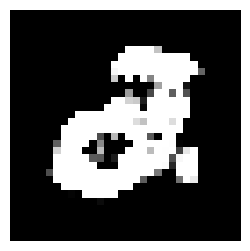

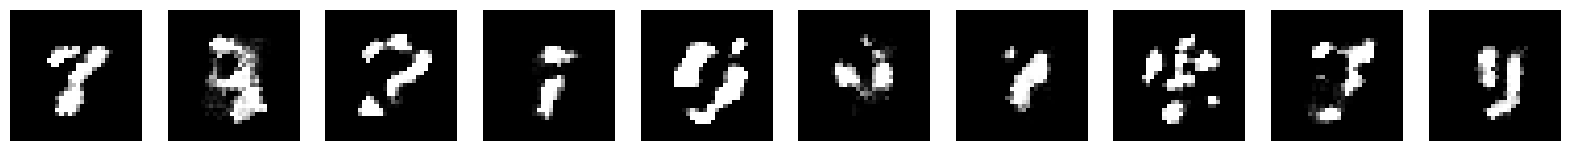

469/469 ━━━━━━━━━━━━━━━━━━━━ 682s 1s/step - cdiv: -0.0512 - fake: 0.1499 - loss: -0.0302 - real: 0.2011 - reg: 0.0209 - val_cdiv: -2.0192 - val_real: -0.0431 - val_fake: -2.0623
Epoch 2/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cdiv: 0.0015 - fake: 0.0042 - loss: 0.0020 - real: 0.0027 - reg: 5.5448e-04

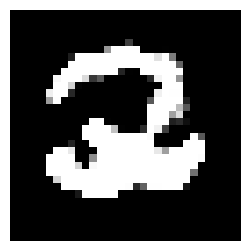

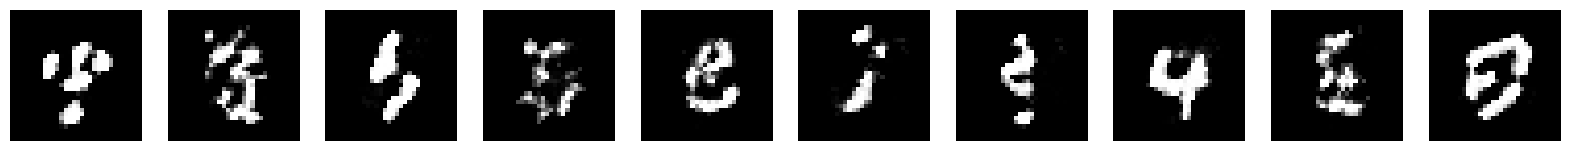

469/469 ━━━━━━━━━━━━━━━━━━━━ 691s 1s/step - cdiv: 0.0015 - fake: 0.0042 - loss: 0.0020 - real: 0.0027 - reg: 5.5416e-04 - val_cdiv: -3.1550 - val_real: -0.0786 - val_fake: -3.2337
Epoch 3/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cdiv: 0.0011 - fake: 0.0024 - loss: 0.0017 - real: 0.0013 - reg: 5.8713e-04

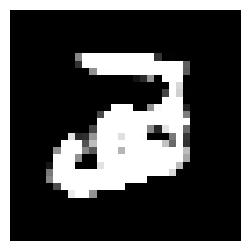

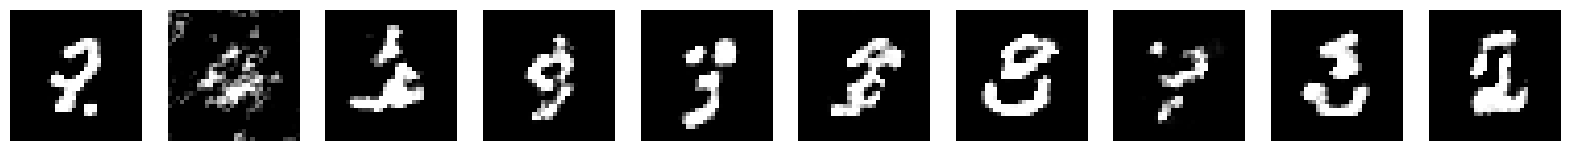

469/469 ━━━━━━━━━━━━━━━━━━━━ 707s 2s/step - cdiv: 0.0011 - fake: 0.0024 - loss: 0.0017 - real: 0.0013 - reg: 5.8694e-04 - val_cdiv: -4.2479 - val_real: -0.0745 - val_fake: -4.3224
Epoch 4/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cdiv: 3.4688e-04 - fake: 6.8266e-04 - loss: 8.5902e-04 - real: 3.3578e-04 - reg: 5.1214e-04

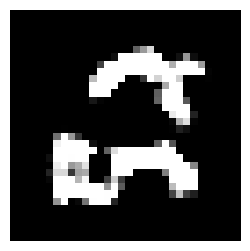

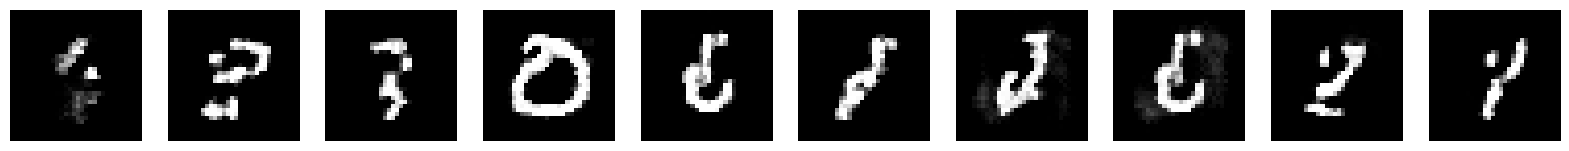

469/469 ━━━━━━━━━━━━━━━━━━━━ 694s 1s/step - cdiv: 3.4650e-04 - fake: 6.8481e-04 - loss: 8.5849e-04 - real: 3.3831e-04 - reg: 5.1198e-04 - val_cdiv: -5.6757 - val_real: -0.0109 - val_fake: -5.6866
Epoch 5/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cdiv: 6.2771e-05 - fake: -0.0013 - loss: 5.2187e-04 - real: -0.0014 - reg: 4.5910e-04

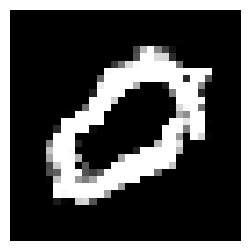

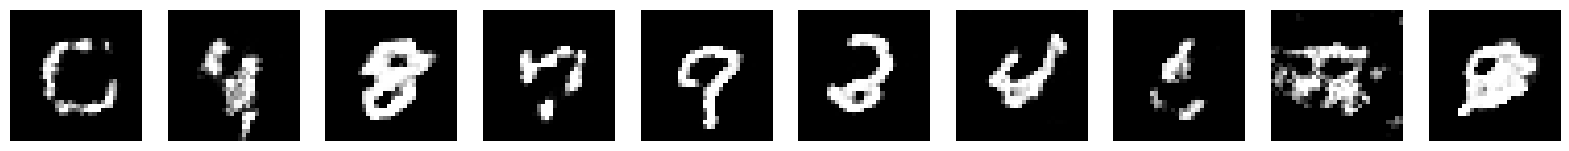

469/469 ━━━━━━━━━━━━━━━━━━━━ 689s 1s/step - cdiv: 6.2654e-05 - fake: -0.0013 - loss: 5.2155e-04 - real: -0.0014 - reg: 4.5890e-04 - val_cdiv: -6.8786 - val_real: 6.4061e-04 - val_fake: -6.8779
Epoch 6/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 4.3620e-04 - fake: 4.4859e-04 - loss: 7.9870e-04 - real: 1.2390e-05 - reg: 3.6249e-04

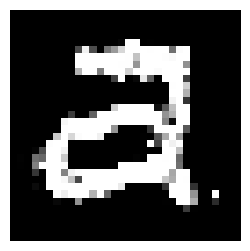

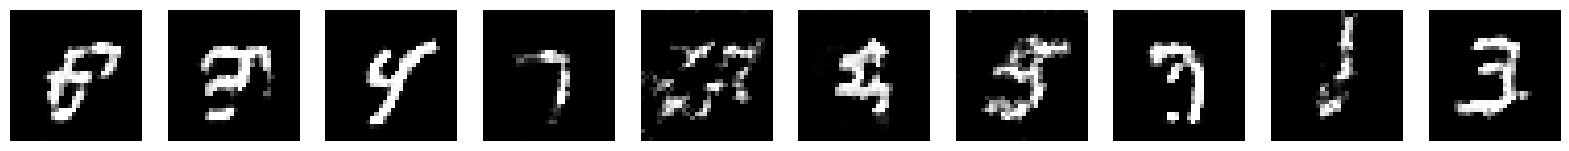

469/469 ━━━━━━━━━━━━━━━━━━━━ 733s 2s/step - cdiv: 4.3568e-04 - fake: 4.4946e-04 - loss: 7.9806e-04 - real: 1.3776e-05 - reg: 3.6237e-04 - val_cdiv: -8.8386 - val_real: 0.0134 - val_fake: -8.8251
Epoch 7/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 7.4390e-04 - fake: 5.9067e-04 - loss: 0.0010 - real: -1.5323e-04 - reg: 2.9167e-04

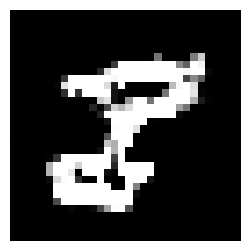

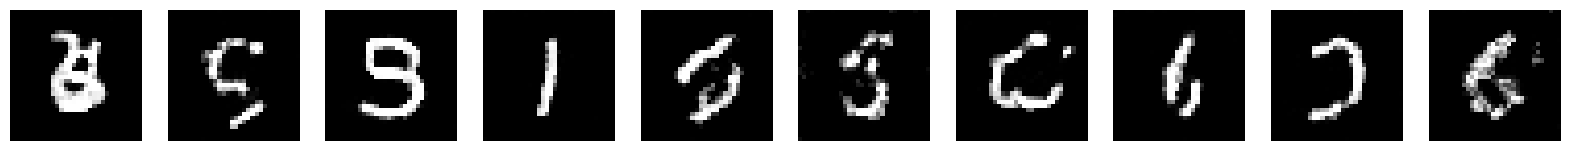

469/469 ━━━━━━━━━━━━━━━━━━━━ 844s 2s/step - cdiv: 7.4265e-04 - fake: 5.9068e-04 - loss: 0.0010 - real: -1.5197e-04 - reg: 2.9160e-04 - val_cdiv: -10.8180 - val_real: 4.5722e-04 - val_fake: -10.8176
Epoch 8/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 6.0678e-04 - fake: 7.4557e-04 - loss: 9.0336e-04 - real: 1.3880e-04 - reg: 2.9658e-04

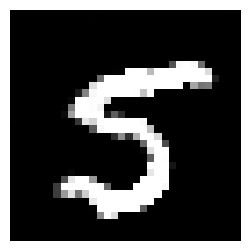

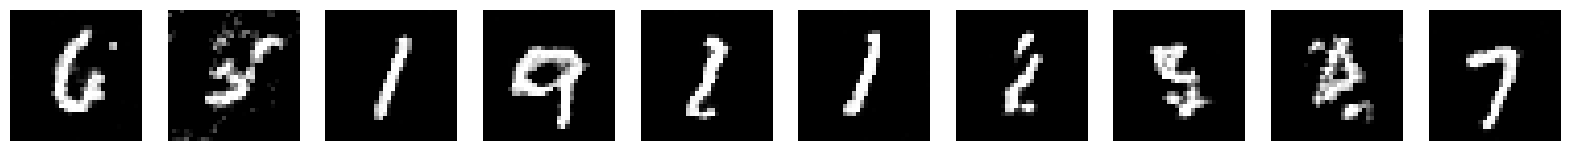

469/469 ━━━━━━━━━━━━━━━━━━━━ 852s 2s/step - cdiv: 6.0608e-04 - fake: 7.4480e-04 - loss: 9.0251e-04 - real: 1.3872e-04 - reg: 2.9643e-04 - val_cdiv: -12.4874 - val_real: 0.0053 - val_fake: -12.4821
Epoch 9/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 5.2846e-04 - fake: 0.0019 - loss: 7.9791e-04 - real: 0.0013 - reg: 2.6945e-04

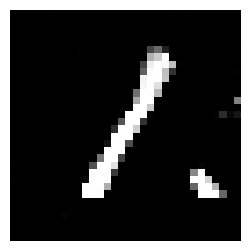

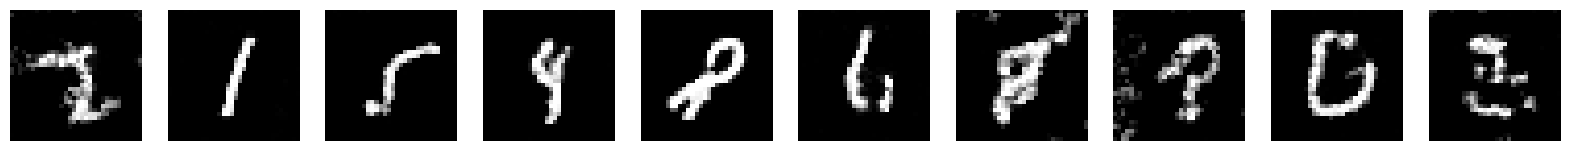

469/469 ━━━━━━━━━━━━━━━━━━━━ 830s 2s/step - cdiv: 5.2777e-04 - fake: 0.0019 - loss: 7.9714e-04 - real: 0.0013 - reg: 2.6938e-04 - val_cdiv: -14.7904 - val_real: -0.0069 - val_fake: -14.7974
Epoch 10/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 5.2674e-04 - fake: 5.6727e-04 - loss: 8.4616e-04 - real: 4.0533e-05 - reg: 3.1942e-04

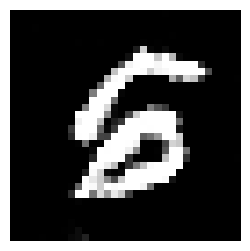

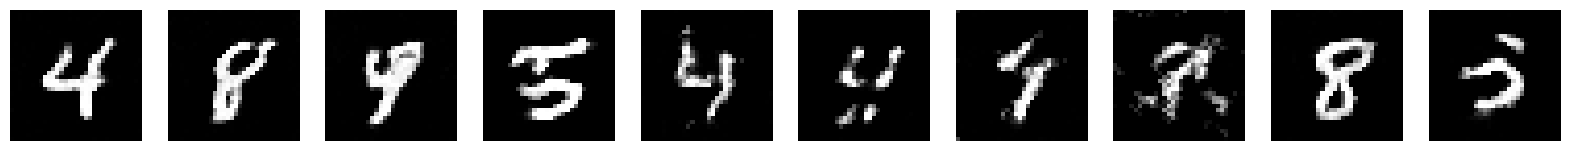

469/469 ━━━━━━━━━━━━━━━━━━━━ 840s 2s/step - cdiv: 5.2613e-04 - fake: 5.6656e-04 - loss: 8.4547e-04 - real: 4.0421e-05 - reg: 3.1933e-04 - val_cdiv: -14.3749 - val_real: -0.0214 - val_fake: -14.3964
Epoch 11/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 6.5976e-04 - fake: 0.0014 - loss: 9.1867e-04 - real: 7.8945e-04 - reg: 2.5892e-04

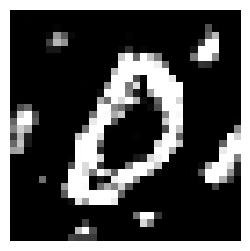

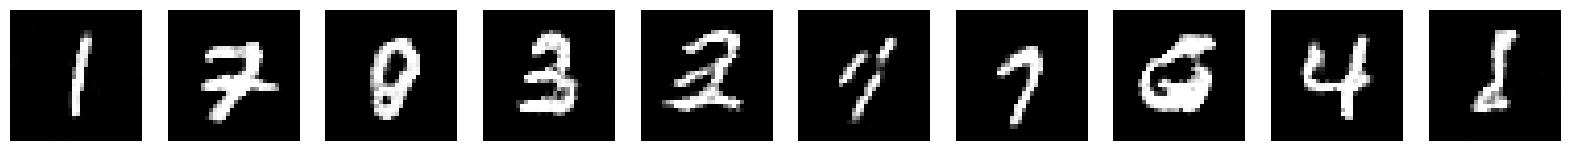

469/469 ━━━━━━━━━━━━━━━━━━━━ 834s 2s/step - cdiv: 6.5914e-04 - fake: 0.0014 - loss: 9.1799e-04 - real: 7.8951e-04 - reg: 2.5885e-04 - val_cdiv: -15.3821 - val_real: 0.0316 - val_fake: -15.3505
Epoch 12/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cdiv: 2.0397e-04 - fake: 0.0023 - loss: 6.3880e-04 - real: 0.0021 - reg: 4.3483e-04

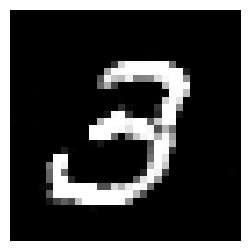

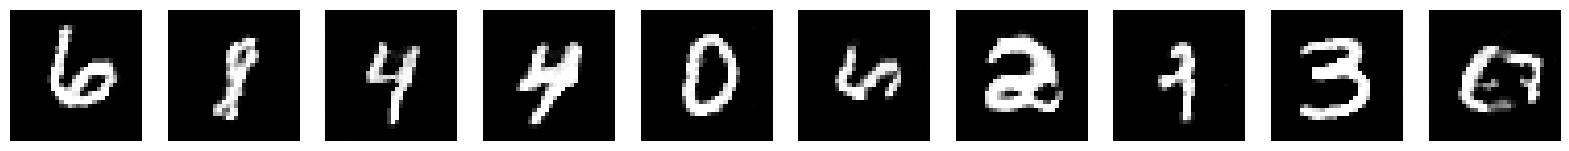

469/469 ━━━━━━━━━━━━━━━━━━━━ 720s 2s/step - cdiv: 2.0392e-04 - fake: 0.0023 - loss: 6.3837e-04 - real: 0.0021 - reg: 4.3445e-04 - val_cdiv: -18.2254 - val_real: 0.0045 - val_fake: -18.2209
Epoch 13/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cdiv: 6.7448e-04 - fake: 0.0018 - loss: 9.0264e-04 - real: 0.0011 - reg: 2.2816e-04

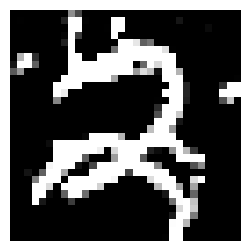

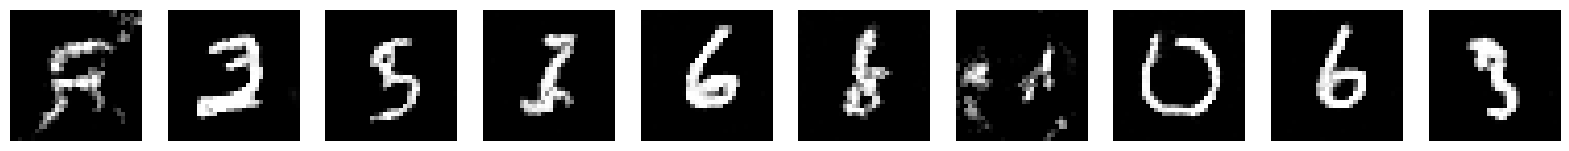

469/469 ━━━━━━━━━━━━━━━━━━━━ 670s 1s/step - cdiv: 6.7392e-04 - fake: 0.0018 - loss: 9.0207e-04 - real: 0.0011 - reg: 2.2816e-04 - val_cdiv: -17.7213 - val_real: 0.0015 - val_fake: -17.7198
Epoch 14/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 5.8594e-04 - fake: 0.0028 - loss: 9.7483e-04 - real: 0.0023 - reg: 3.8888e-04

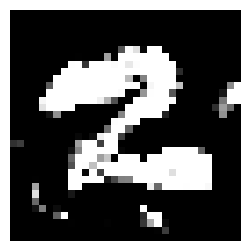

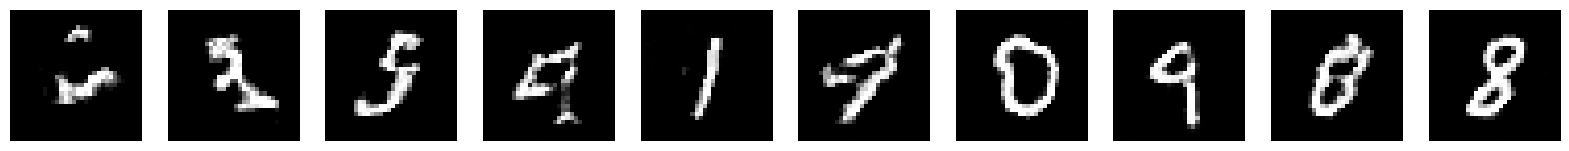

469/469 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - cdiv: 5.8543e-04 - fake: 0.0028 - loss: 9.7416e-04 - real: 0.0023 - reg: 3.8872e-04 - val_cdiv: -17.7678 - val_real: -0.0150 - val_fake: -17.7828
Epoch 15/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 2.8624e-04 - fake: 0.0028 - loss: 5.9325e-04 - real: 0.0025 - reg: 3.0702e-04

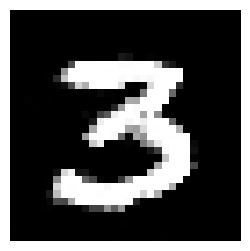

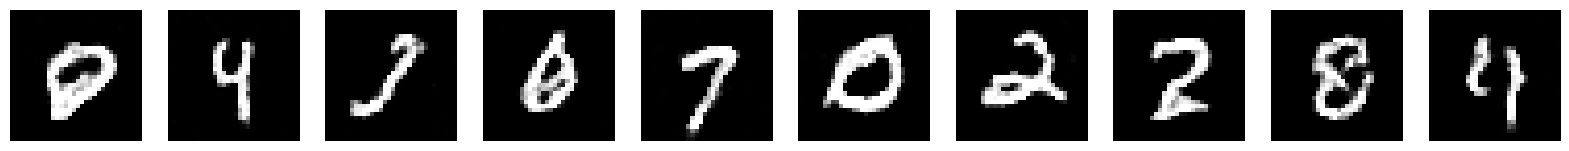

469/469 ━━━━━━━━━━━━━━━━━━━━ 778s 2s/step - cdiv: 2.8631e-04 - fake: 0.0027 - loss: 5.9325e-04 - real: 0.0025 - reg: 3.0695e-04 - val_cdiv: -17.5071 - val_real: 0.0074 - val_fake: -17.4996
Epoch 16/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: -7.4325e-05 - fake: 0.0013 - loss: 2.8471e-04 - real: 0.0014 - reg: 3.5904e-04

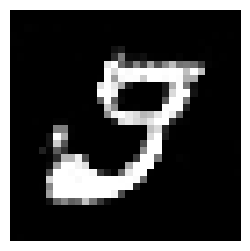

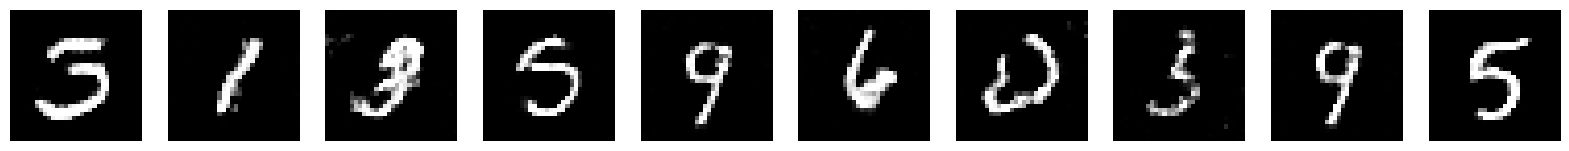

469/469 ━━━━━━━━━━━━━━━━━━━━ 795s 2s/step - cdiv: -7.3951e-05 - fake: 0.0013 - loss: 2.8494e-04 - real: 0.0014 - reg: 3.5889e-04 - val_cdiv: -17.7917 - val_real: 0.0191 - val_fake: -17.7725
Epoch 17/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 3.2315e-04 - fake: 0.0017 - loss: 6.0282e-04 - real: 0.0014 - reg: 2.7967e-04

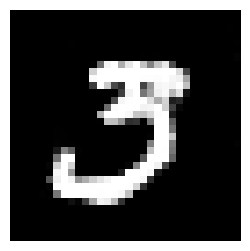

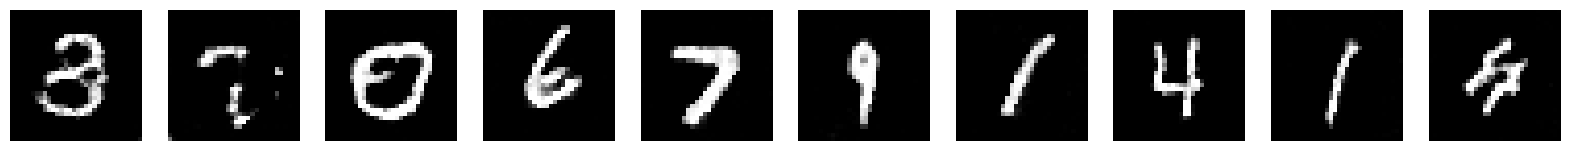

469/469 ━━━━━━━━━━━━━━━━━━━━ 820s 2s/step - cdiv: 3.2303e-04 - fake: 0.0017 - loss: 6.0270e-04 - real: 0.0014 - reg: 2.7967e-04 - val_cdiv: -17.8293 - val_real: 0.0108 - val_fake: -17.8185
Epoch 18/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 2.2426e-04 - fake: 0.0018 - loss: 4.7949e-04 - real: 0.0016 - reg: 2.5523e-04

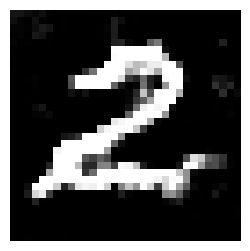

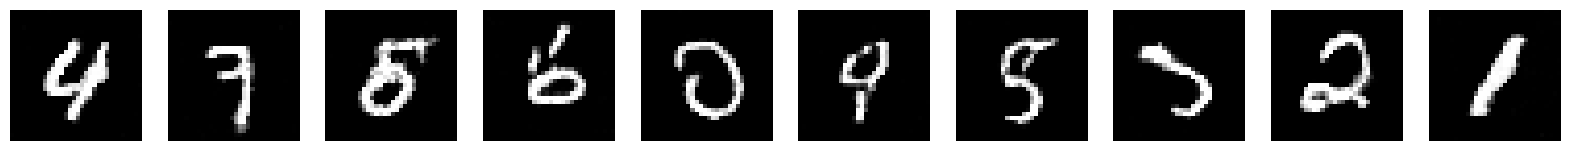

469/469 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - cdiv: 2.2466e-04 - fake: 0.0018 - loss: 4.7985e-04 - real: 0.0016 - reg: 2.5519e-04 - val_cdiv: -16.0066 - val_real: 0.0405 - val_fake: -15.9660
Epoch 19/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 2.3843e-05 - fake: 0.0025 - loss: 2.8554e-04 - real: 0.0024 - reg: 2.6170e-04

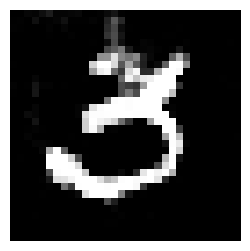

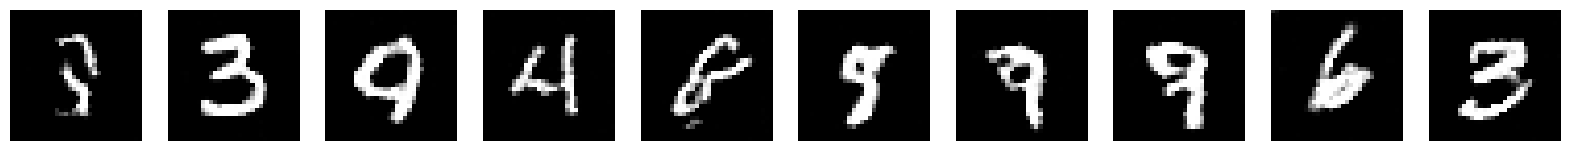

469/469 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - cdiv: 2.4140e-05 - fake: 0.0024 - loss: 2.8580e-04 - real: 0.0024 - reg: 2.6166e-04 - val_cdiv: -18.7020 - val_real: 0.0256 - val_fake: -18.6765
Epoch 20/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: -4.3049e-06 - fake: 0.0020 - loss: 2.1169e-04 - real: 0.0020 - reg: 2.1600e-04

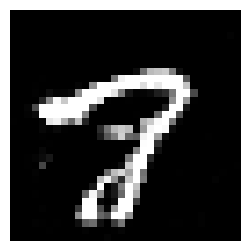

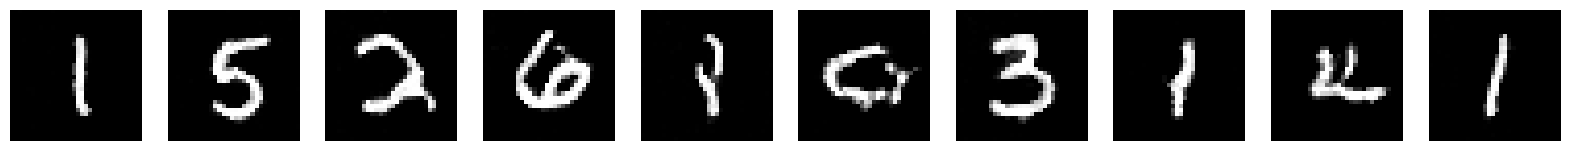

469/469 ━━━━━━━━━━━━━━━━━━━━ 984s 2s/step - cdiv: -3.7377e-06 - fake: 0.0020 - loss: 2.1219e-04 - real: 0.0020 - reg: 2.1593e-04 - val_cdiv: -17.7200 - val_real: -0.0230 - val_fake: -17.7430
Epoch 21/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: -1.3930e-04 - fake: 6.6931e-04 - loss: 3.2227e-04 - real: 8.0861e-04 - reg: 4.6158e-04

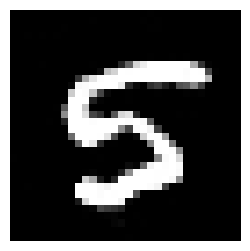

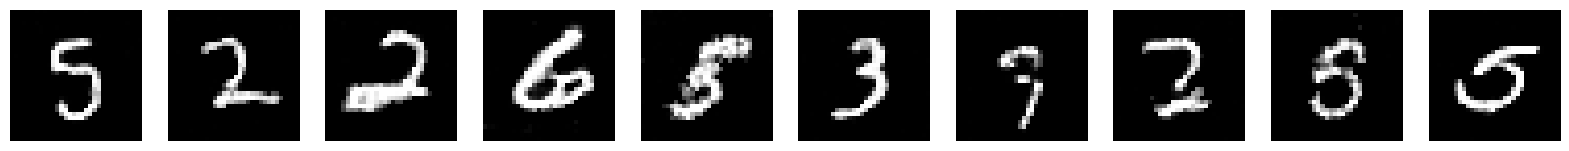

469/469 ━━━━━━━━━━━━━━━━━━━━ 914s 2s/step - cdiv: -1.3884e-04 - fake: 6.6894e-04 - loss: 3.2234e-04 - real: 8.0778e-04 - reg: 4.6117e-04 - val_cdiv: -19.3878 - val_real: -0.0118 - val_fake: -19.3996
Epoch 22/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 1.0080e-04 - fake: 8.8621e-04 - loss: 3.9434e-04 - real: 7.8541e-04 - reg: 2.9354e-04

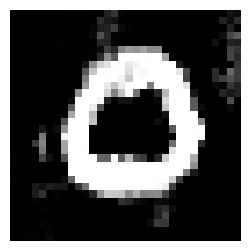

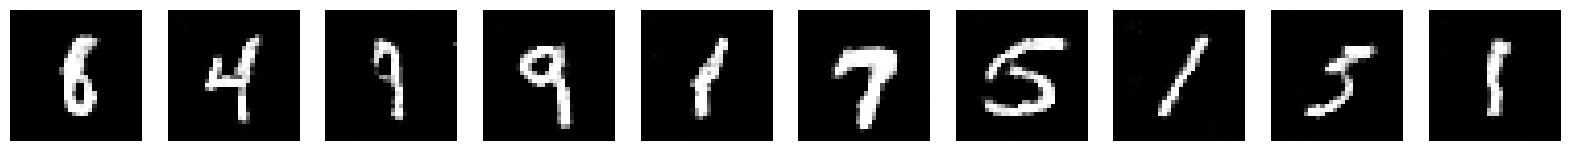

469/469 ━━━━━━━━━━━━━━━━━━━━ 964s 2s/step - cdiv: 1.0109e-04 - fake: 8.8432e-04 - loss: 3.9455e-04 - real: 7.8323e-04 - reg: 2.9345e-04 - val_cdiv: -19.0408 - val_real: -0.0106 - val_fake: -19.0514
Epoch 23/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 1.2115e-04 - fake: 0.0023 - loss: 3.5520e-04 - real: 0.0022 - reg: 2.3406e-04

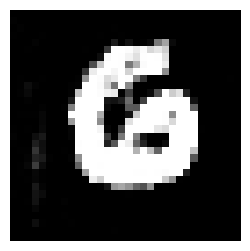

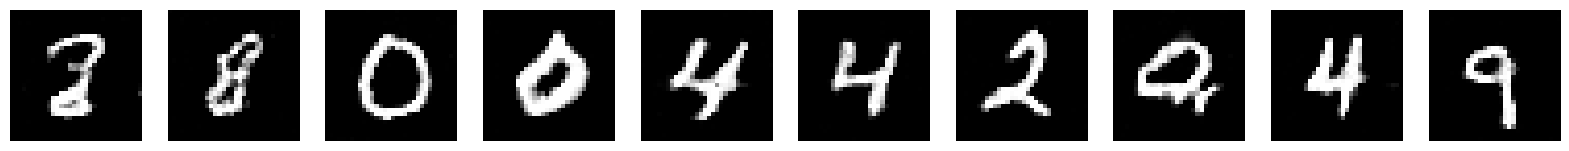

469/469 ━━━━━━━━━━━━━━━━━━━━ 858s 2s/step - cdiv: 1.2113e-04 - fake: 0.0023 - loss: 3.5523e-04 - real: 0.0022 - reg: 2.3410e-04 - val_cdiv: -18.6771 - val_real: -0.0248 - val_fake: -18.7019
Epoch 24/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 8.7983e-05 - fake: 0.0011 - loss: 3.5312e-04 - real: 0.0010 - reg: 2.6514e-04

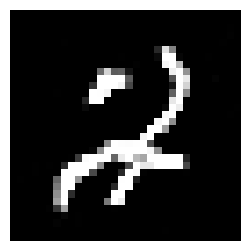

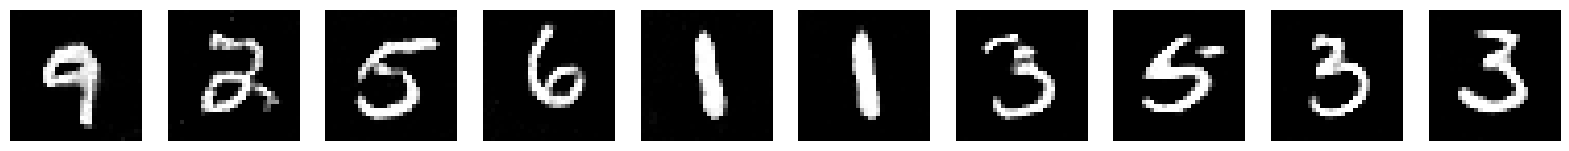

469/469 ━━━━━━━━━━━━━━━━━━━━ 874s 2s/step - cdiv: 8.8087e-05 - fake: 0.0011 - loss: 3.5330e-04 - real: 0.0010 - reg: 2.6522e-04 - val_cdiv: -17.8917 - val_real: -0.0314 - val_fake: -17.9231
Epoch 25/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: -1.7690e-04 - fake: -4.8603e-04 - loss: 1.2005e-04 - real: -3.0914e-04 - reg: 2.9695e-04

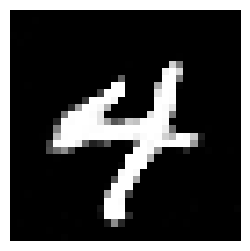

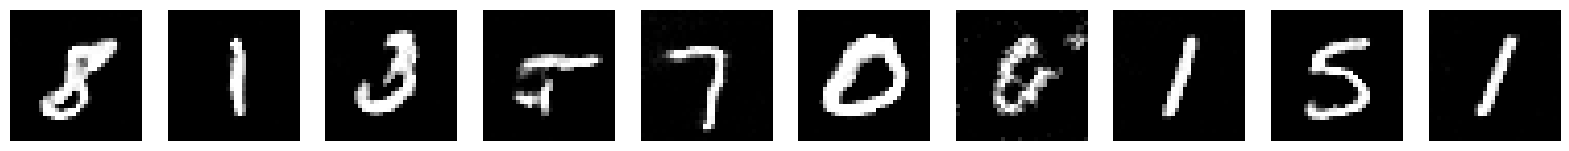

469/469 ━━━━━━━━━━━━━━━━━━━━ 968s 2s/step - cdiv: -1.7648e-04 - fake: -4.8548e-04 - loss: 1.2036e-04 - real: -3.0900e-04 - reg: 2.9684e-04 - val_cdiv: -17.6631 - val_real: -0.0282 - val_fake: -17.6913
Epoch 26/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 7.3514e-05 - fake: 0.0015 - loss: 4.2881e-04 - real: 0.0014 - reg: 3.5530e-04

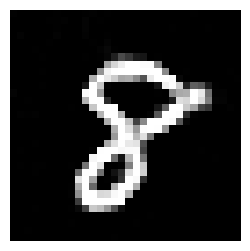

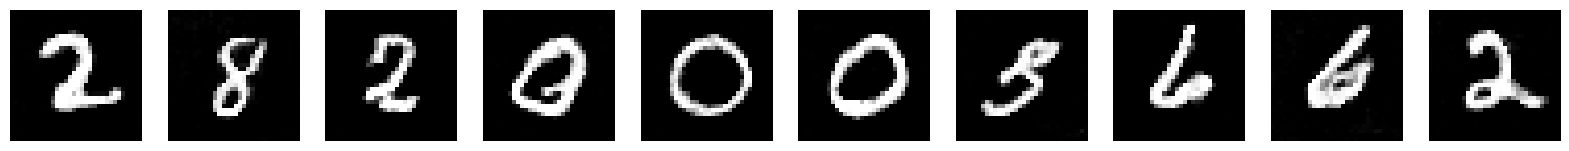

469/469 ━━━━━━━━━━━━━━━━━━━━ 895s 2s/step - cdiv: 7.3219e-05 - fake: 0.0015 - loss: 4.2848e-04 - real: 0.0014 - reg: 3.5526e-04 - val_cdiv: -19.9726 - val_real: -0.0062 - val_fake: -19.9788
Epoch 27/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cdiv: 3.9958e-04 - fake: 0.0014 - loss: 6.5410e-04 - real: 9.6720e-04 - reg: 2.5452e-04

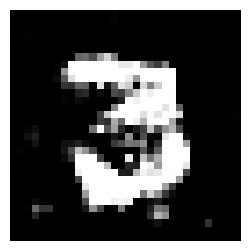

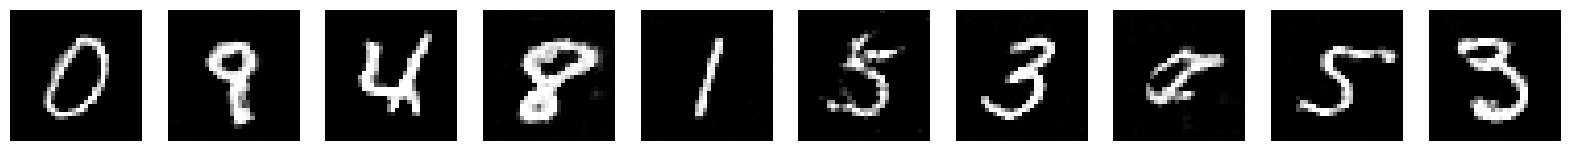

469/469 ━━━━━━━━━━━━━━━━━━━━ 722s 2s/step - cdiv: 3.9895e-04 - fake: 0.0014 - loss: 6.5346e-04 - real: 9.6453e-04 - reg: 2.5451e-04 - val_cdiv: -19.8855 - val_real: 0.0057 - val_fake: -19.8798
Epoch 28/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 7.0949e-05 - fake: 0.0029 - loss: 4.0006e-04 - real: 0.0028 - reg: 3.2911e-04

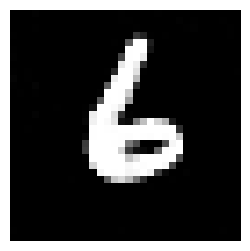

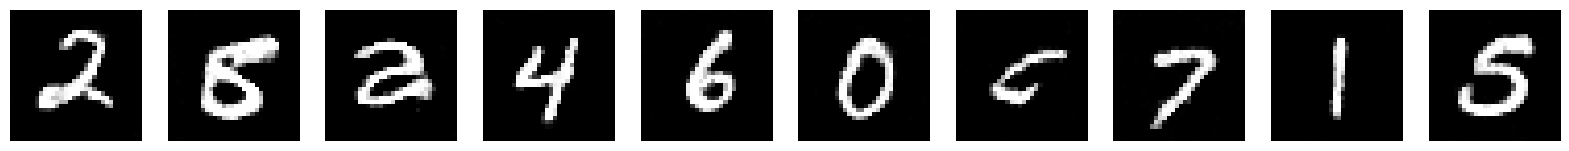

469/469 ━━━━━━━━━━━━━━━━━━━━ 762s 2s/step - cdiv: 7.0803e-05 - fake: 0.0029 - loss: 3.9971e-04 - real: 0.0028 - reg: 3.2891e-04 - val_cdiv: -18.0850 - val_real: 1.0341e-04 - val_fake: -18.0849
Epoch 29/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 2.9965e-04 - fake: 0.0028 - loss: 5.7605e-04 - real: 0.0025 - reg: 2.7640e-04

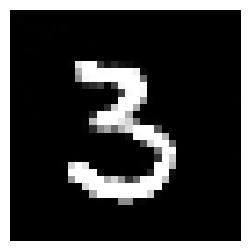

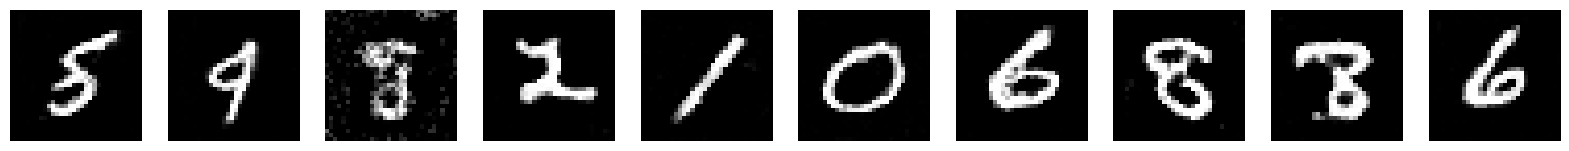

469/469 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - cdiv: 2.9925e-04 - fake: 0.0028 - loss: 5.7567e-04 - real: 0.0025 - reg: 2.7642e-04 - val_cdiv: -13.8769 - val_real: -0.0370 - val_fake: -13.9139
Epoch 30/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: -7.2351e-05 - fake: 1.7602e-04 - loss: 1.5486e-04 - real: 2.4837e-04 - reg: 2.2721e-04

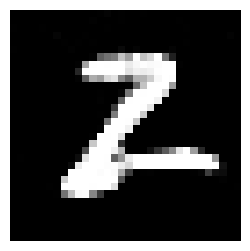

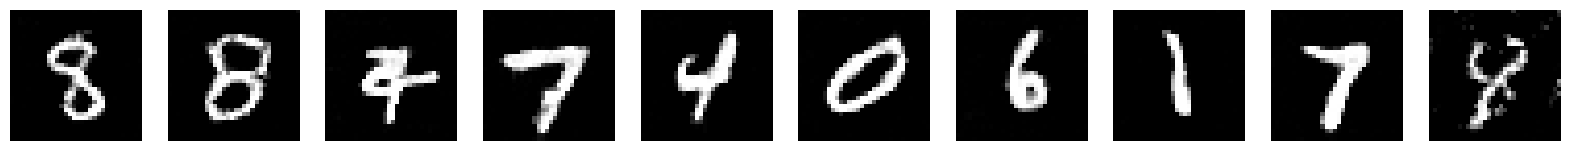

469/469 ━━━━━━━━━━━━━━━━━━━━ 907s 2s/step - cdiv: -7.2251e-05 - fake: 1.7514e-04 - loss: 1.5491e-04 - real: 2.4739e-04 - reg: 2.2716e-04 - val_cdiv: -15.0054 - val_real: -0.0275 - val_fake: -15.0329
Epoch 31/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 2.7628e-05 - fake: 0.0023 - loss: 3.4511e-04 - real: 0.0023 - reg: 3.1748e-04

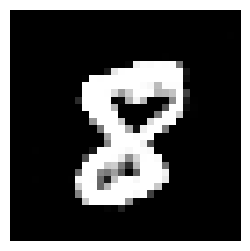

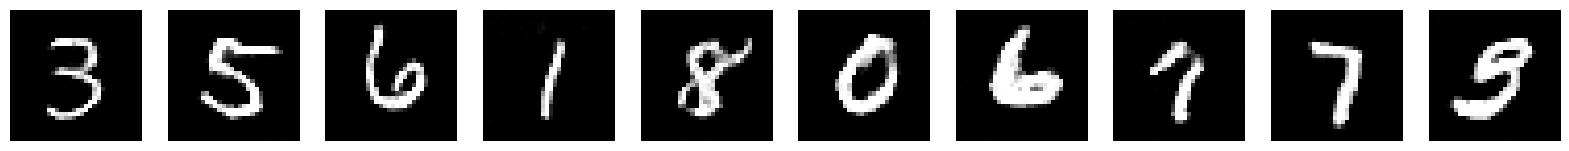

469/469 ━━━━━━━━━━━━━━━━━━━━ 970s 2s/step - cdiv: 2.7692e-05 - fake: 0.0023 - loss: 3.4510e-04 - real: 0.0023 - reg: 3.1741e-04 - val_cdiv: -16.6901 - val_real: -0.0692 - val_fake: -16.7593
Epoch 32/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 1.3868e-04 - fake: 9.3823e-04 - loss: 4.1757e-04 - real: 7.9955e-04 - reg: 2.7889e-04

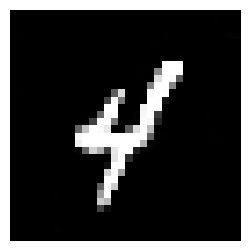

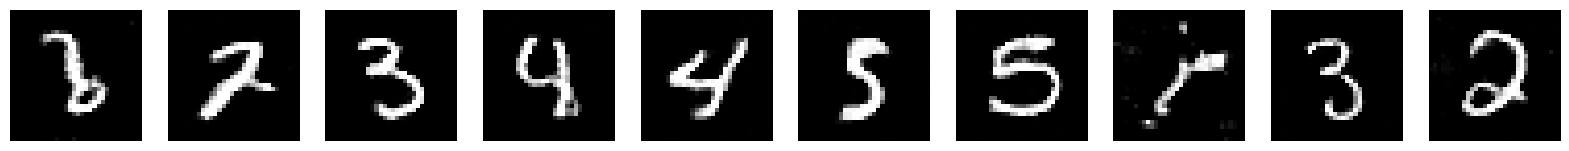

469/469 ━━━━━━━━━━━━━━━━━━━━ 783s 2s/step - cdiv: 1.3796e-04 - fake: 9.3706e-04 - loss: 4.1683e-04 - real: 7.9910e-04 - reg: 2.7887e-04 - val_cdiv: -17.0498 - val_real: -0.0519 - val_fake: -17.1017
Epoch 33/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: -2.6686e-04 - fake: 0.0018 - loss: 1.3088e-04 - real: 0.0021 - reg: 3.9773e-04

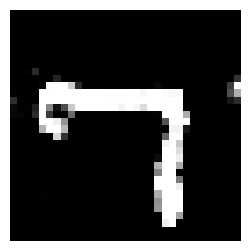

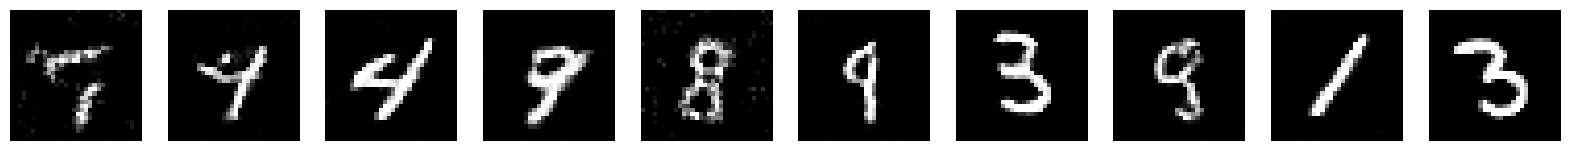

469/469 ━━━━━━━━━━━━━━━━━━━━ 729s 2s/step - cdiv: -2.6651e-04 - fake: 0.0018 - loss: 1.3096e-04 - real: 0.0021 - reg: 3.9746e-04 - val_cdiv: -16.9126 - val_real: -0.0508 - val_fake: -16.9634
Epoch 34/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 5.6449e-05 - fake: -1.6944e-04 - loss: 3.6677e-04 - real: -2.2589e-04 - reg: 3.1032e-04

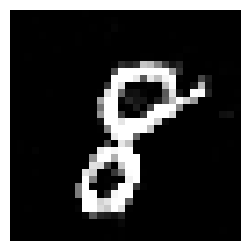

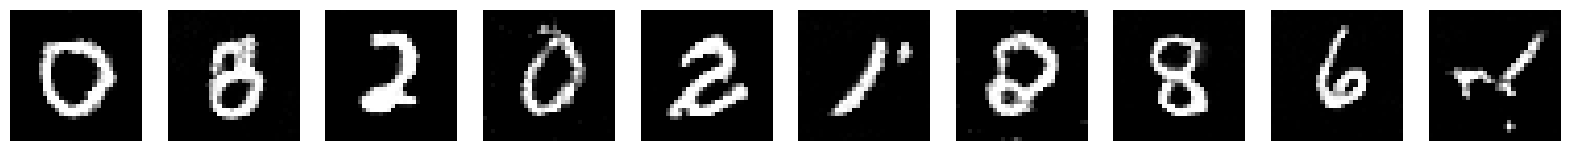

469/469 ━━━━━━━━━━━━━━━━━━━━ 750s 2s/step - cdiv: 5.6189e-05 - fake: -1.6871e-04 - loss: 3.6642e-04 - real: -2.2490e-04 - reg: 3.1023e-04 - val_cdiv: -15.1638 - val_real: -0.0213 - val_fake: -15.1851
Epoch 35/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: -5.6869e-04 - fake: -5.7855e-04 - loss: -3.6987e-05 - real: -9.8513e-06 - reg: 5.3171e-04

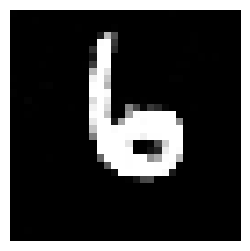

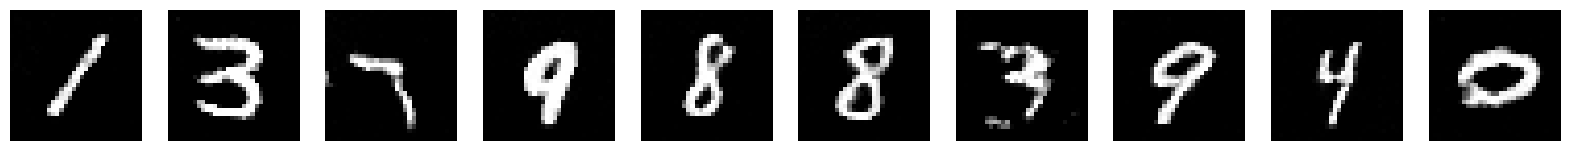

469/469 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - cdiv: -5.6821e-04 - fake: -5.7698e-04 - loss: -3.6913e-05 - real: -8.7709e-06 - reg: 5.3130e-04 - val_cdiv: -17.3147 - val_real: -0.0194 - val_fake: -17.3342
Epoch 36/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: 2.9113e-05 - fake: 1.7275e-05 - loss: 3.7395e-04 - real: -1.1838e-05 - reg: 3.4484e-04

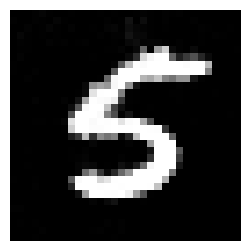

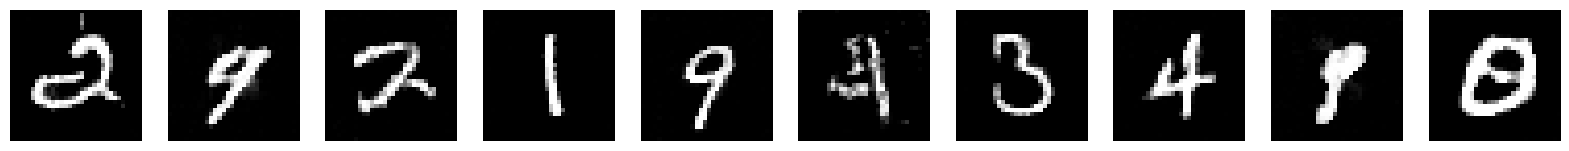

469/469 ━━━━━━━━━━━━━━━━━━━━ 764s 2s/step - cdiv: 2.9246e-05 - fake: 1.6022e-05 - loss: 3.7391e-04 - real: -1.3224e-05 - reg: 3.4467e-04 - val_cdiv: -21.6357 - val_real: -0.0025 - val_fake: -21.6382
Epoch 37/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - cdiv: -5.2733e-04 - fake: 4.0322e-04 - loss: -2.1504e-04 - real: 9.3054e-04 - reg: 3.1228e-04

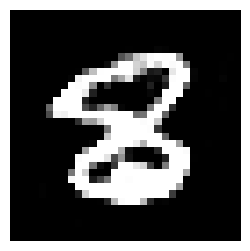

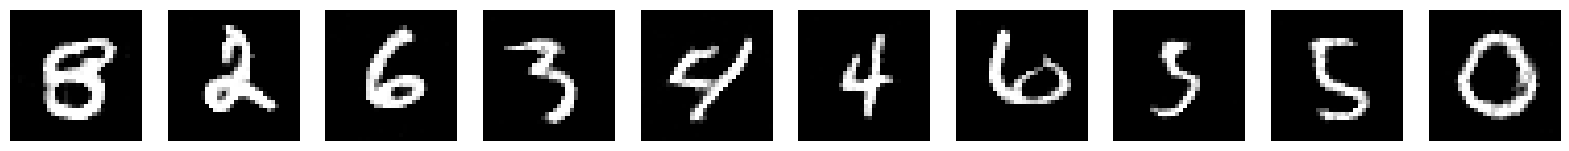

469/469 ━━━━━━━━━━━━━━━━━━━━ 796s 2s/step - cdiv: -5.2704e-04 - fake: 3.9981e-04 - loss: -2.1471e-04 - real: 9.2685e-04 - reg: 3.1233e-04 - val_cdiv: -18.1679 - val_real: -0.0286 - val_fake: -18.1965
Epoch 38/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cdiv: 9.5701e-05 - fake: 0.0035 - loss: 4.9107e-04 - real: 0.0034 - reg: 3.9537e-04

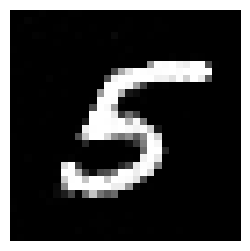

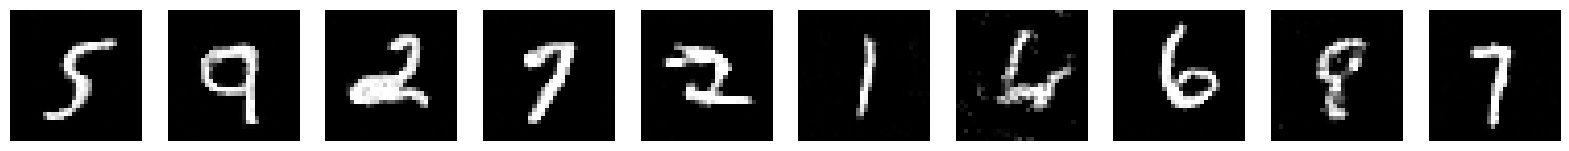

469/469 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - cdiv: 9.4996e-05 - fake: 0.0035 - loss: 4.9028e-04 - real: 0.0034 - reg: 3.9528e-04 - val_cdiv: -18.3882 - val_real: 0.0047 - val_fake: -18.3834
Epoch 39/60
 44/469 ━━━━━━━━━━━━━━━━━━━━ 2:16:42 19s/step - cdiv: -0.0036 - fake: 0.0084 - loss: -0.0028 - real: 0.0121 - reg: 8.4379e-04

In [ ]:
%%time

x_test_r = x_test.take(1)
x_train_r = x_train.take(1)
ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        tensorboard_callback,
        image_generator_callback
    ]
)

## Generate new images

In [1]:
start_imgs = np.random.uniform(size = (10, 32, 32, 1)) * 2 - 1
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=10,
    noise = 0.005,
    return_img_per_step=True,
)

NameError: name 'np' is not defined

**References**

1. [Generative Deep Learning, 2nd Edition](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/): David Foster's book from which has become an inspiration of this notebook.
2. [David Foster](https://github.com/davidADSP): GitHub page
3. [David Foster (Keynote) - Generative Deep Learning -Key To Unlocking Artificial General Intelligence?](https://www.youtube.com/watch?v=rHLf78CmNmQ): David's video session at Youtube regarding some key concepts has written in his book
4. [Gradient Tape in TensorFlow - 1 ](https://www.youtube.com/watch?app=desktop&v=kq6mpyjSQ3w) Great tutorial with basic explanation of gradients in TF.Keras
5. [Gradient Tape in TensorFlow - 2 ](https://www.youtube.com/watch?v=ODPjd05FmkI) More details of the tf.keras gradient
6. [Gradient Tape in TensorFlow - 3 ](https://www.youtube.com/watch?v=sohJNTWwcSw) More details of the tf.keras gradient
7. [The Energy-Based Learning Model](https://www.youtube.com/watch?v=4lthJd3DNTM) Great lecture in the subject of EBM by Yann LeCun 
8. [Tutorial 8: Deep Energy-Based Generative Models](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html) Phillip Lippe's amazing tutorial with very deep explanation of EBM